In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Epoch 1, Batch 100, Loss: 0.147
Validation Loss: 1.391
*****************************
Epoch 2, Batch 100, Loss: 0.089
Validation Loss: 0.935
*****************************
Epoch 3, Batch 100, Loss: 0.026
Validation Loss: 0.623
*****************************
Epoch 4, Batch 100, Loss: 0.011
Validation Loss: 0.494
*****************************
Epoch 5, Batch 100, Loss: 0.008
Validation Loss: 0.415
*****************************
Epoch 6, Batch 100, Loss: 0.007
Validation Loss: 0.359
*****************************
Epoch 7, Batch 100, Loss: 0.006
Validation Loss: 0.307
*****************************
Epoch 8, Batch 100, Loss: 0.005
Validation Loss: 0.270
*****************************
Epoch 9, Batch 100, Loss: 0.004
Validation Loss: 0.235
*****************************
Epoch 10, Batch 100, Loss: 0.003
Validation Loss: 0.202
*****************************
Epoch 11, Batch 100, Loss: 0.003
Validation Loss: 0.183
*****************************
Epoch 12, Batch 100, Loss: 0.003
Validation Loss: 0.162
*******

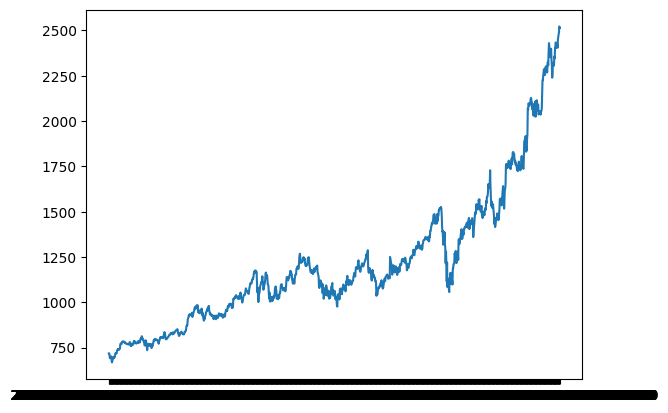

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Setting the device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Loading and plotting the data
data = pd.read_csv('/kaggle/input/google-stock-prediction/GOOG.csv')
data = data[['date', 'adjClose']]
plt.plot(data['date'], data['adjClose'])

# Preparing the dataframe for LSTM
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    for i in range(1, n_steps + 1):
        df[f'close(t-{i})'] = df['adjClose'].shift(i)
    
    df.dropna(inplace=True)
    return df

lookback = 5
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df_as_np = shifted_df.to_numpy()

# Scaling the data
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

# Splitting the data
split_index = int(len(X) * 0.95)  # 95% train, 5% test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshaping the data
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Creating tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

# Creating the dataset and dataloader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

batch_size = 8
train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size, shuffle=False)

# Defining the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size=1, hidden_size=4, num_layers=1).to(device)

# Training function
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    for batch_index, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (batch_index + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}, Batch {batch_index + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

# Validation function
def validate_one_epoch():
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    avg_loss = running_loss / len(test_loader)
    print(f'Validation Loss: {avg_loss:.3f}')
    print('*****************************')

# Training the model
learning_rate = 0.001
num_epochs = 70
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    validate_one_epoch()
